# Beta Bank Churn Analysis

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from collections import Counter

In [2]:
# Load the dataset
data = pd.read_csv('./Churn.csv')
display(data.head())
data.info()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


A coluna `RowNumber` e `Surname` parece irrelevante para nossa tarefa, vamos remove-las e manter a `CustomerId` apenas para identificacao do cliente, ela nao vai entrar no modelo. Tambem observamos valores nulos na coluna `Tenure`, podemos definir com 0 assumindo que esse cliente ainda nao tem 1 ano de maturacao completo.

In [3]:
# remove a coluna 'RowNumber' e 'Surname'
data = data.drop(columns=['RowNumber', 'Surname'], axis=1)

# Trocar valores nulos em 'Tenure' por 0
data['Tenure'] = data['Tenure'].fillna(0)

as clases numericas possuem um grande desequilibrio com valores altos que significam saldo ou score divergindo de valores 0 e 1 que tratam de sim ou nao e ate numero de produtos que sao ordinais.

In [4]:
# Separando o objetivo do dataset
x = data.drop(columns=['Exited'], axis=1)
y = data['Exited']

# dando labels para as variáveis categóricas
labelencoder = LabelEncoder()
geographyEncoder = labelencoder.fit(x['Geography'])
x['Geography'] = geographyEncoder.transform(x['Geography'])
# futuramente deixar esses dados salvos em um arquivo pickle para não precisar fazer isso toda vez

# Convertendo as variáveis categóricas em variáveis dummy
x = pd.get_dummies(x, drop_first=True)

# Separando os dados de treino e validação
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.75, random_state=12345)

Usei o labelEncoder nas colunas que podem ser classificadas como legenda de varias linhas e o dummy onde seria uma legenda menor.

In [5]:
# Treinando o modelo
model = RandomForestClassifier(n_estimators=100, random_state=12345)
model.fit(x_train, y_train)

# Fazendo previsões
y_pred = model.predict(x_test)

# Avaliando o modelo
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred))
print("\nROC AUC Score:")
print(roc_auc_score(y_test, y_pred))
print("\nF1 Score:")
print(f1_score(y_test, y_pred))


Confusion Matrix:
[[1894   71]
 [ 306  229]]

Accuracy Score:
0.8492

ROC AUC Score:
0.6959525338279707

F1 Score:
0.548502994011976


Temos um f1_score um pouco longe do esperado que seria 0.59, a acuracia me parece bem promisora, e observando a matriz de confusao, observamos o elevado numero de Falsos Positivos, agora vamos equilibrar os dados para ver qual sera o comportamento.

In [6]:
print(f"Original dataset shape {Counter(y_train)}")
smote = SMOTE(random_state=12345)
x_res, y_res = smote.fit_resample(x_train, y_train)
print(f"Reamostrado dataset shape {Counter(y_res)}")

Original dataset shape Counter({0: 5998, 1: 1502})
Reamostrado dataset shape Counter({0: 5998, 1: 5998})


Agora temos um dataset de treinamento com valores iguais de uns e zeros. sendo assim mais equilibrado e esperamos que consigamos melhorar as metricas com isso.

In [7]:
# Treinando o modelo
model = RandomForestClassifier(n_estimators=100, random_state=12345)
model.fit(x_res, y_res)

# Fazendo previsões
y_pred = model.predict(x_test)

# Avaliando o modelo
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred))
print("\nROC AUC Score:")
print(roc_auc_score(y_test, y_pred))
print("\nF1 Score:")
print(f1_score(y_test, y_pred))


Confusion Matrix:
[[1679  286]
 [ 209  326]]

Accuracy Score:
0.802

ROC AUC Score:
0.7318993603005874

F1 Score:
0.5684394071490846


Aqui ja pudemos observar uma boa mehoria na metrica f1_score que e nosso objetivo, mas vemos tambem uma queda na acuracia em geral. Vou trabalhar mais um pouco no balanceamento dos dados para buscar melhorias.

In [ ]:
# Definindo os parâmetros para o GridSearchCV
param_grid = {
    'n_estimators': [320, 350, 370],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [15, 20, 25],
    'min_samples_split': [12, 15, 18],
    'min_samples_leaf': [1, 2, 3],
    'class_weight': ['balanced', None],
}

# Criando o modelo RandomForestClassifier
rf = RandomForestClassifier(random_state=12345)

# Criando o GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=3, scoring='f1')

# Ajustando o GridSearchCV aos dados de treino
grid_search.fit(x_res.loc[:, 'CreditScore':'Gender_Male'], y_res)

# Imprimindo os melhores parâmetros encontrados
print("Melhores parâmetros encontrados:")
print(grid_search.best_params_)
# Imprimindo o melhor score
print("Melhor score encontrado:")
print(grid_search.best_score_)
# Fazendo previsões com o melhor modelo encontrado
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(x_test.loc[:, 'CreditScore':'Gender_Male'])
# Avaliando o melhor modelo
print("\nConfusion Matrix do melhor modelo:")
print(confusion_matrix(y_test, y_pred_best))
print("\nAccuracy Score do melhor modelo:")
print(accuracy_score(y_test, y_pred_best))
print("\nROC AUC Score do melhor modelo:")
print(roc_auc_score(y_test, y_pred_best))
print("\nF1 Score do melhor modelo:")
print(f1_score(y_test, y_pred_best))

Apos obter os hiperparametros otimizados para nosso objetivo, f1_score >= 0.59, treinei o modelo com eles abaixo.

In [9]:
# Treinando o modelo
model = RandomForestClassifier(n_estimators=350, random_state=12345, max_depth=20,
                               min_samples_split=15, min_samples_leaf=1, max_features='sqrt')

# Treinando o modelo com os melhores parâmetros encontrados
model.fit(x_res.loc[:, 'CreditScore':'Gender_Male'], y_res)

# Fazendo previsões
y_pred = model.predict(x_test.loc[:, 'CreditScore':'Gender_Male'])

# Avaliando o modelo
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred))
print("\nROC AUC Score:")
print(roc_auc_score(y_test, y_pred))
print("\nF1 Score:")
print(f1_score(y_test, y_pred))


Confusion Matrix:
[[1674  291]
 [ 185  350]]

Accuracy Score:
0.8096

ROC AUC Score:
0.7530570022116001

F1 Score:
0.5952380952380952


Mesmo perdendo em acuracia total, conseguimos melhorar o AUC-ROC o que nos diz que o modelo melhorou a capacidade de disntiguir positivos de negativos, ja nosso f1_score passou do objetivo, o que nos da uma boa media de equilibrio entre a sensibilidade e a precisao.

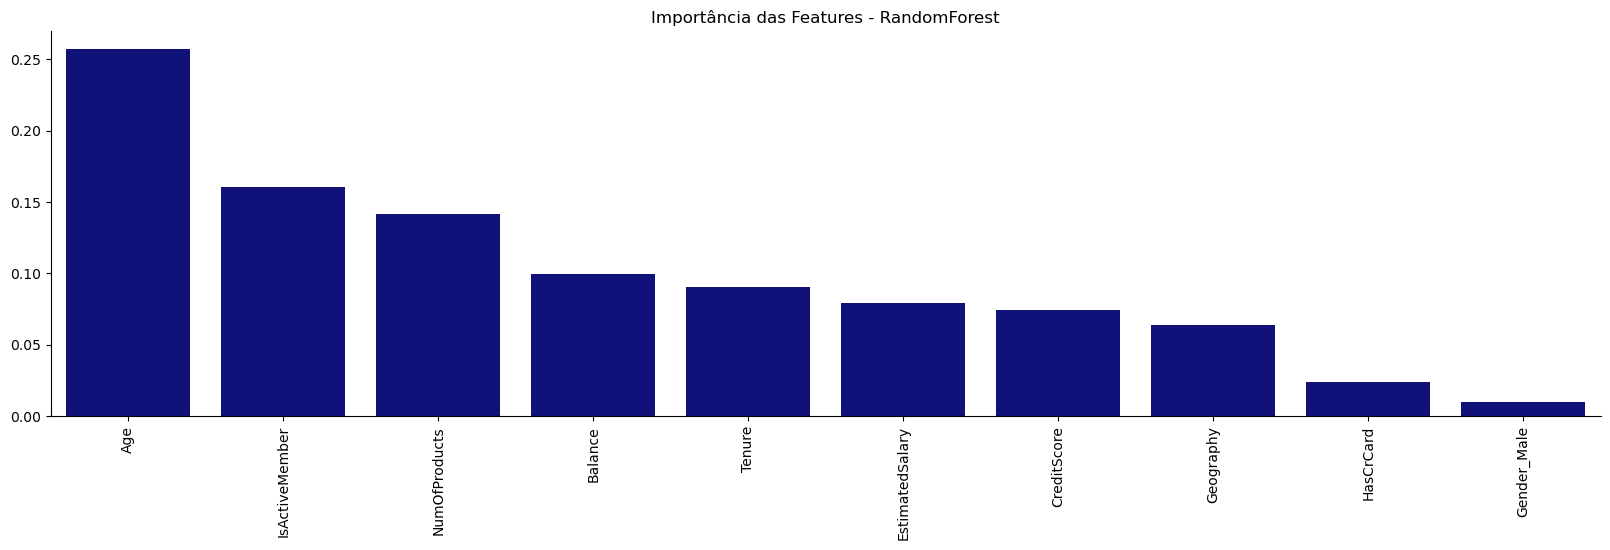

In [10]:
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns

importances = model.feature_importances_
indexes = np.argsort(importances)[::-1]

coef = importances[indexes]
features = x_res.loc[:, 'CreditScore':'Gender_Male'].columns
# Supondo que 'features' seja a lista de nomes das colunas
features_array = np.array(features)

# Plotar gráfico de barras
fig, ax = plt.subplots(figsize=(20, 5))
sns.barplot(x=features_array[indexes], y=coef, ax=ax, color='darkblue')
plt.xticks(rotation=90)
sns.despine()

plt.title("Importância das Features - RandomForest")
plt.show()

Aqui podemos ver qual a importancia de cada coluna no modelo, podemos fazer mais alguns ajustes com isso ou ate algumas analise do tipo: a idade e um fator importante na rotatividade de clientes.